# Metabolomic Analysis of Egg Yolk From Conventional, Organic, and Crossover Production (Reversed-Phase Chromatography, Positive Ionization Mode)
This notebook uses several packages from CRAN, as well as [Bioconductor](https://bioconductor.org). For a full list of attached packages see the session info in the Appendix at the end of this notebook. Several options have been adjusted to improve appearance of plots.

## Quality Control of Raw Data

In [1]:
## Load necessary packages
suppressMessages({
    
    library("xcms")
    library("CAMERA")
    library("RColorBrewer")
    library("SummarizedExperiment")
    library("tidyverse")
    library("gplots")
    library("Rtsne")
    library("caret")
    library("MASS")
    library("ggrepel")
    library("writexl")
    
})

## Set session-specific options
options(repr.plot.width = 12, repr.plot.height = 6, repr.plot.res = 120, scipen = -1)

## Define %notin% operator
`%notin%` <- Negate(`%in%`)

In [2]:
## List mzXML files
mzMLs <- list.files(recursive = TRUE, full.names = TRUE, pattern = ".mzML")

## Aggregate meta data
sample.name <- sub(basename(mzMLs), pattern = ".mzML", 
                   replacement = "", fixed = TRUE)
sample.group <- c(rep("A", 5), rep("B", 5), rep("Bio", 5), rep("Boden", 6), 
                  rep("C", 5), rep("D", 1), rep("QC", 8))
sample.weight <- c(103.5, 100.3, 100.8, 101.6, 99.8, 99.7, 99.4, 99.8, 
                   99.3, 99.0, 102.5, 102.2, 101.9, 102.6, 101.8, 103.3, 
                   103.7, 100.7, 102.2, 98.8, 99.0, 102.2, 101.7, 100.8, 
                   101.9, 99.3, 101.0, NA, NA, NA, NA, NA, NA, NA, NA)
sample.weight[is.na(sample.weight) == TRUE] <- mean(sample.weight, na.rm = TRUE) %>%
                                               round(0)
analysis.order <- c(28, 18, 14, 25, 21, 30, 23, 17, 7, 20, 6, 15 ,22, 10, 
                    13, 34, 29, 33, 32, 8, 9, 31, 11, 26, 24, 19, 12, 1, 
                    2, 3, 4, 5, 16, 27, 35)
analysis.batch <- NA
meta <- data.frame(sample_name = sample.name, 
                   sample_group = sample.group,
                   sample_weight = sample.weight,
                   analysis_order = analysis.order, 
                   analysis_batch = analysis.batch, 
                   stringsAsFactors = FALSE)

In [3]:
## Read raw data from disk
raw <- readMSData(files = mzMLs[order(analysis.order)], 
                  pdata = new("AnnotatedDataFrame", 
                              meta[order(analysis.order),]), 
                  mode = "onDisk")

## Inspection of Internal Standards
This experiment used the following stable isotope labeled standards to normalise variability introduced by injection of the samples into the mass spectrometer:
- creatinine-d3, \[M+H\]: *m/z* 117.0856
- tryptophan-d5, \[M+H\]: *m/z* 210.1285, \[M-H\]: *m/z* 208.1140
- glucose-d7, \[M-H\]: *m/z* 186.1000
- palmitic acid-31, \[M-H\]: *m/z* 286.4275

Quality control at this stage includes ensuring that the internal standards have been detected properly and the within group variability is acceptable.

In [4]:
## Define colours for experimental groups
group.colours <- paste0(brewer.pal(7, "Dark2")[1:7])
names(group.colours) <- c("A", "B", "C", "D", "Bio", "Boden", "QC")

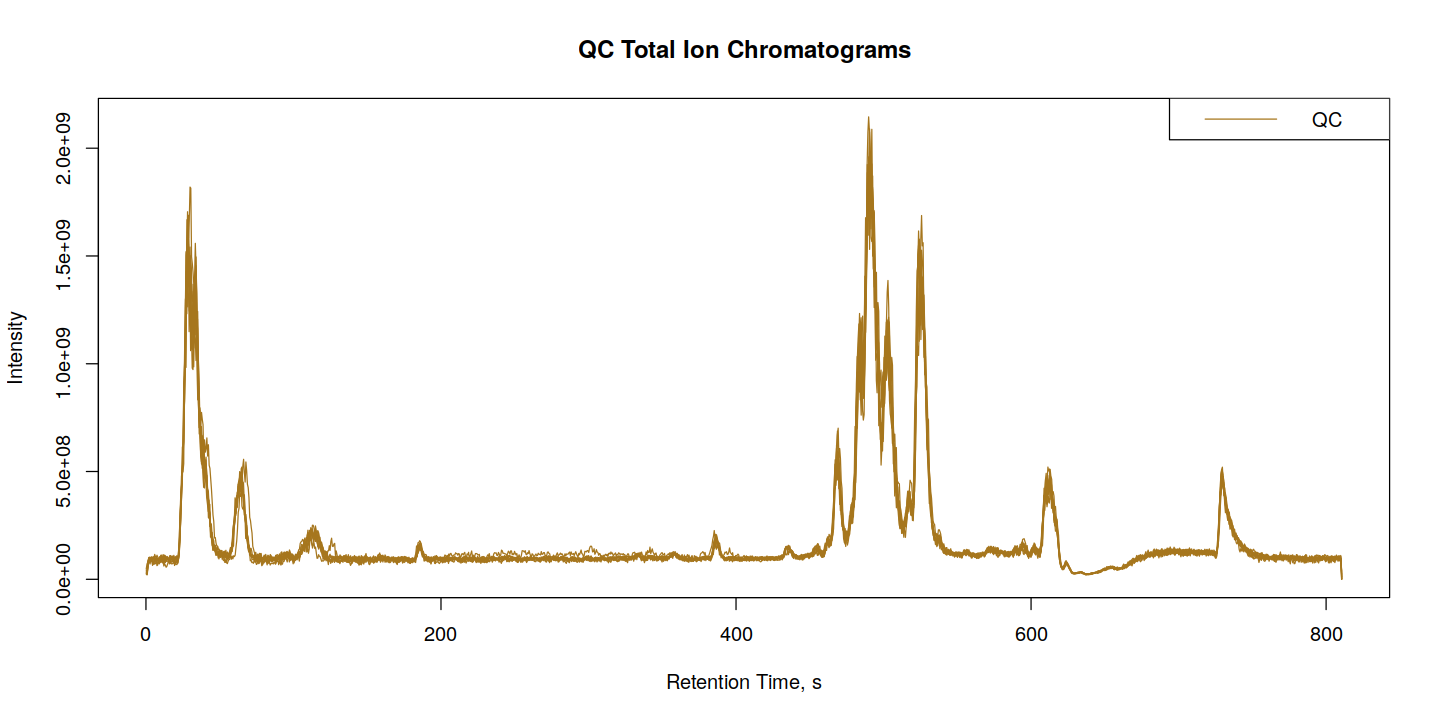

In [5]:
## Get TIC chromatograms
chroms <- chromatogram(raw)

## Plot every QC chromatogram of the data set
plot(chroms[,chroms$sample_group == "QC"], col = group.colours[chroms$sample_group],
     main = "QC Total Ion Chromatograms", ylab = "Intensity", 
     xlab = "Retention Time, s")
legend("topright", legend = "QC", 
       col = group.colours[names(group.colours) == "QC"], lty = 1)

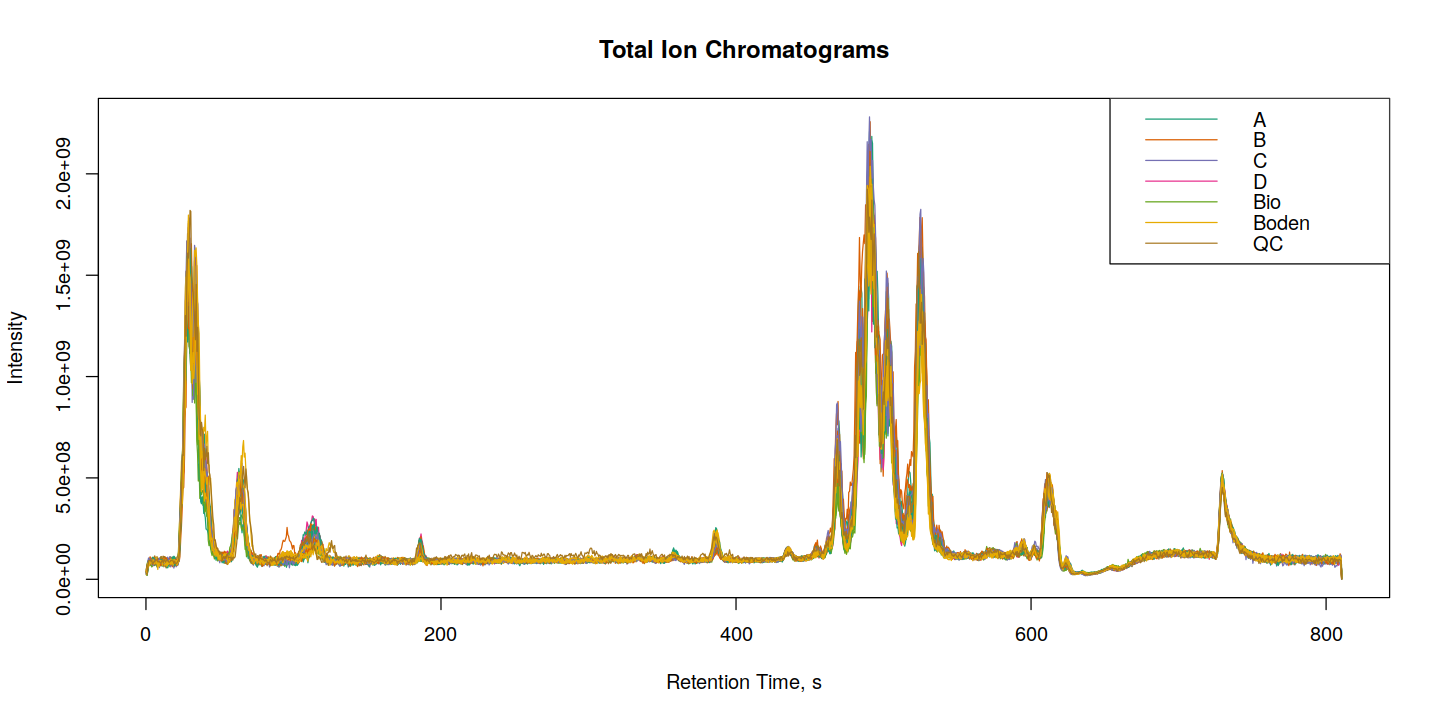

In [6]:
## Plot every chromatogram of the data set
plot(chroms, col = group.colours[chroms$sample_group],
     main = "Total Ion Chromatograms", ylab = "Intensity", 
     xlab = "Retention Time, s")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

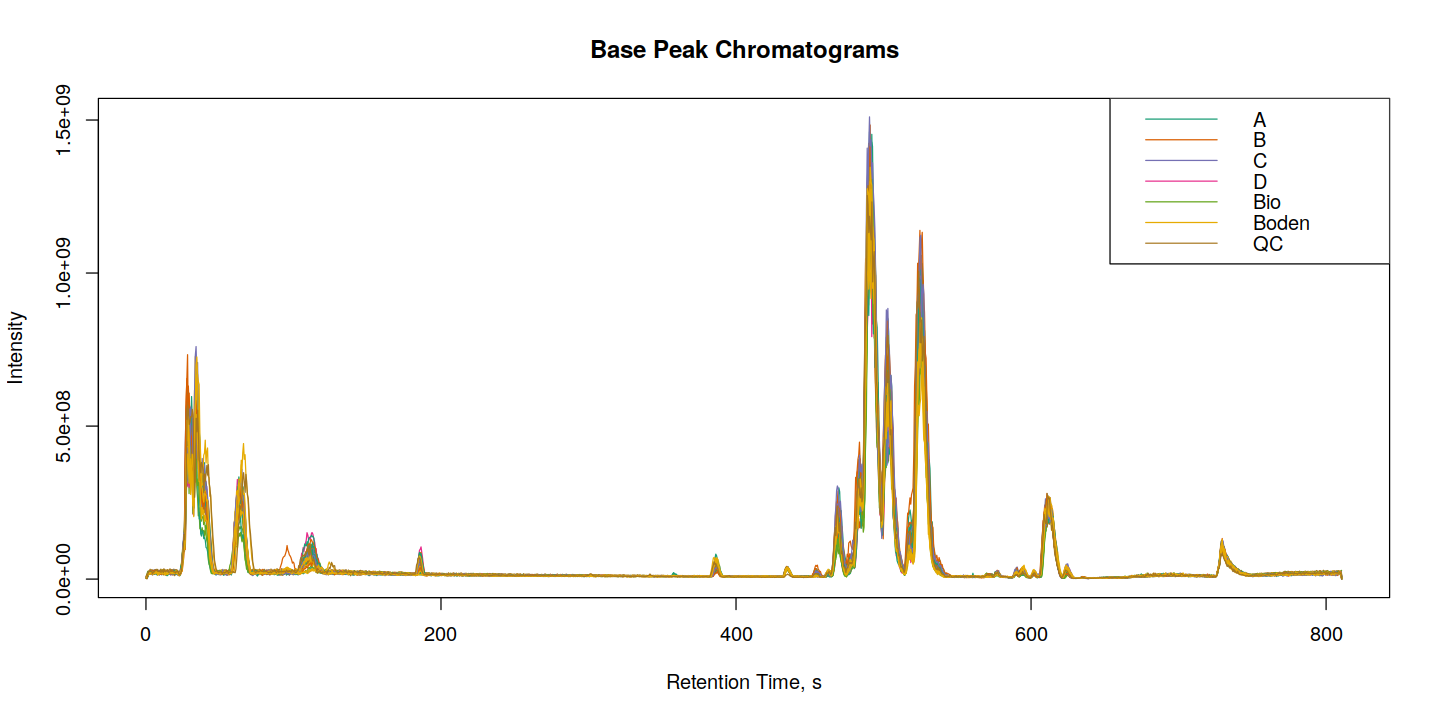

In [7]:
## Get base peak chromatograms
bps <- chromatogram(raw, aggregationFun = "max")

## Plot every base peak chromatogram of the data set
plot(bps, col = group.colours[raw$sample_group], 
     main = "Base Peak Chromatograms", ylab = "Intensity", 
     xlab = "Retention Time, s")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

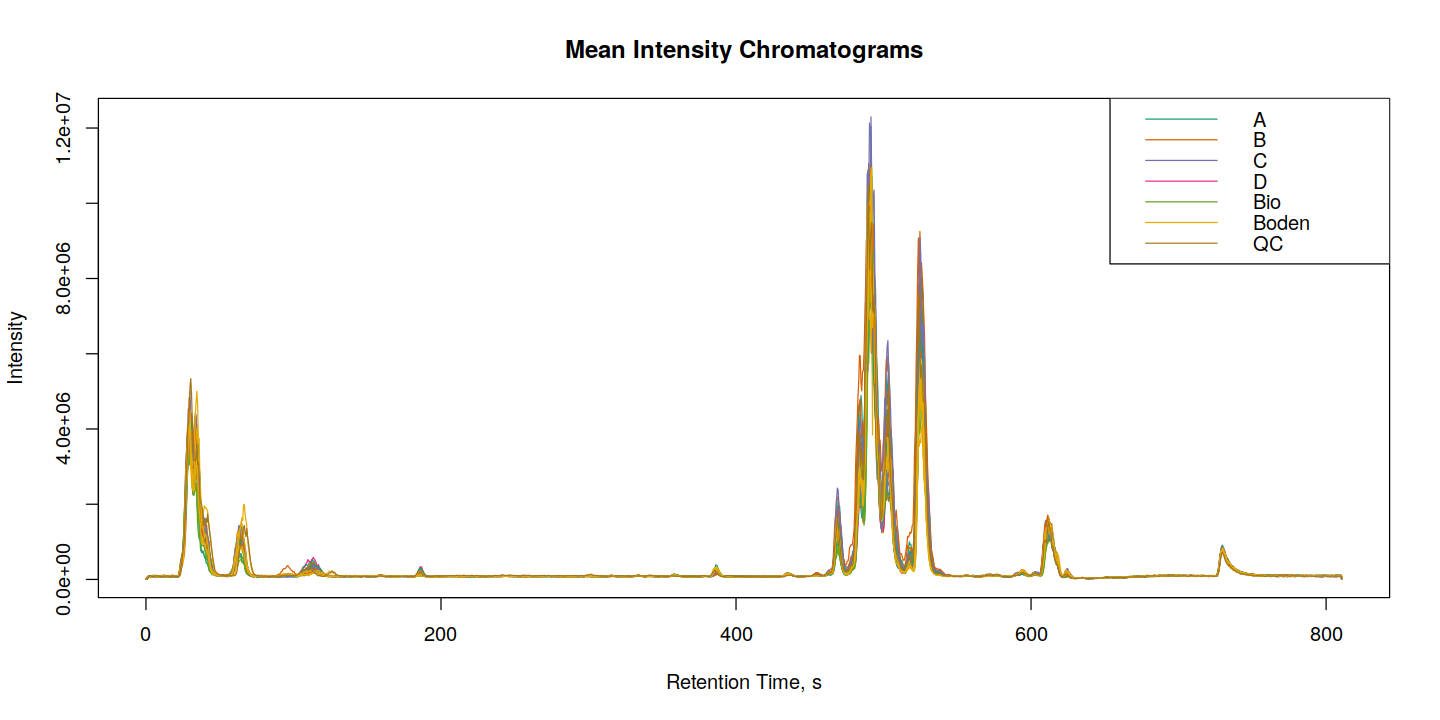

In [8]:
## Get mean intensity chromatograms
means <- chromatogram(raw, aggregationFun = "mean")

## Plot every mean intensity chromatogram of the data set
plot(means, col = group.colours[raw$sample_group], 
     main = "Mean Intensity Chromatograms", ylab = "Intensity", 
     xlab = "Retention Time, s")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

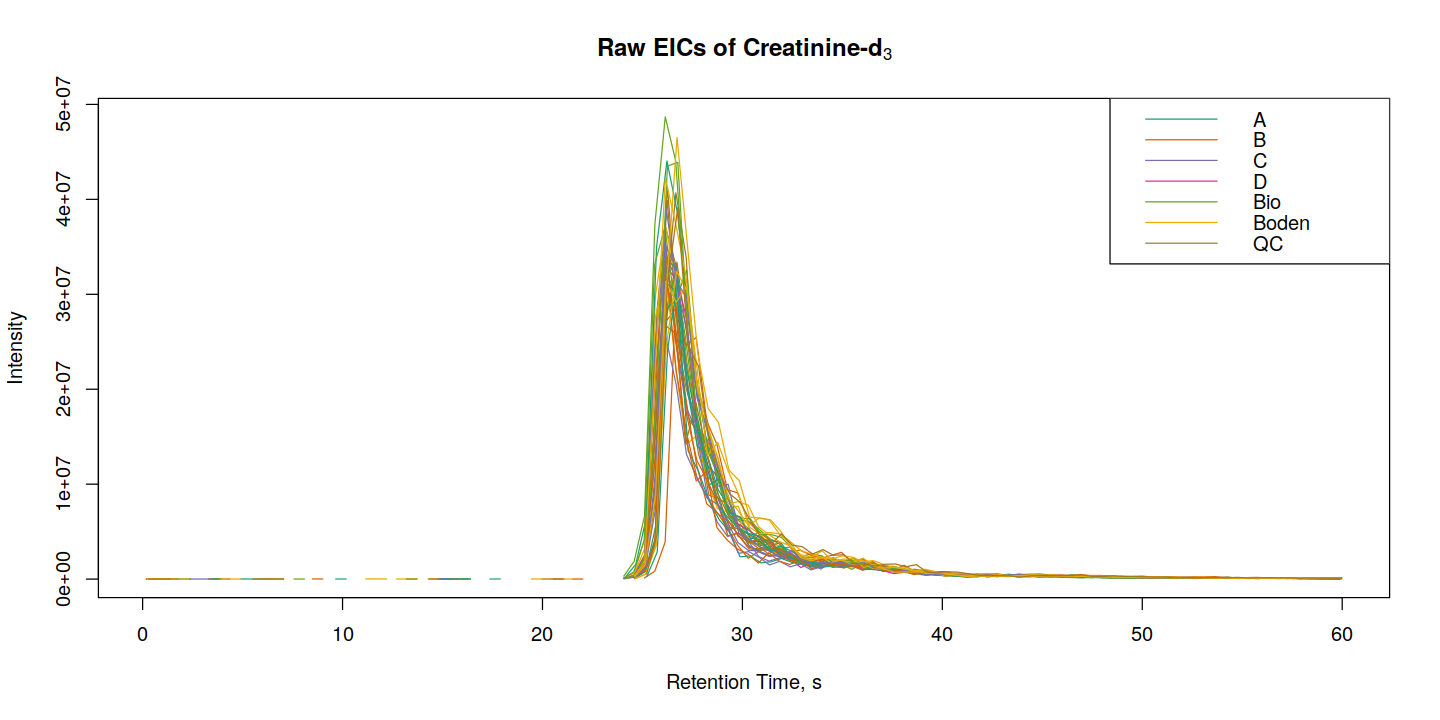

In [9]:
## Plot creatinine-d3 before processing
cread3.raw <- chromatogram(raw, mz = c(117.0851, 117.0861), rt = c(0, 60)) 

plot(cread3.raw, col = group.colours[cread3.raw$sample_group], 
     main = bquote(bold("Raw EICs of Creatinine-d"[3])), xlab = "Retention Time, s", ylab = "Intensity")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

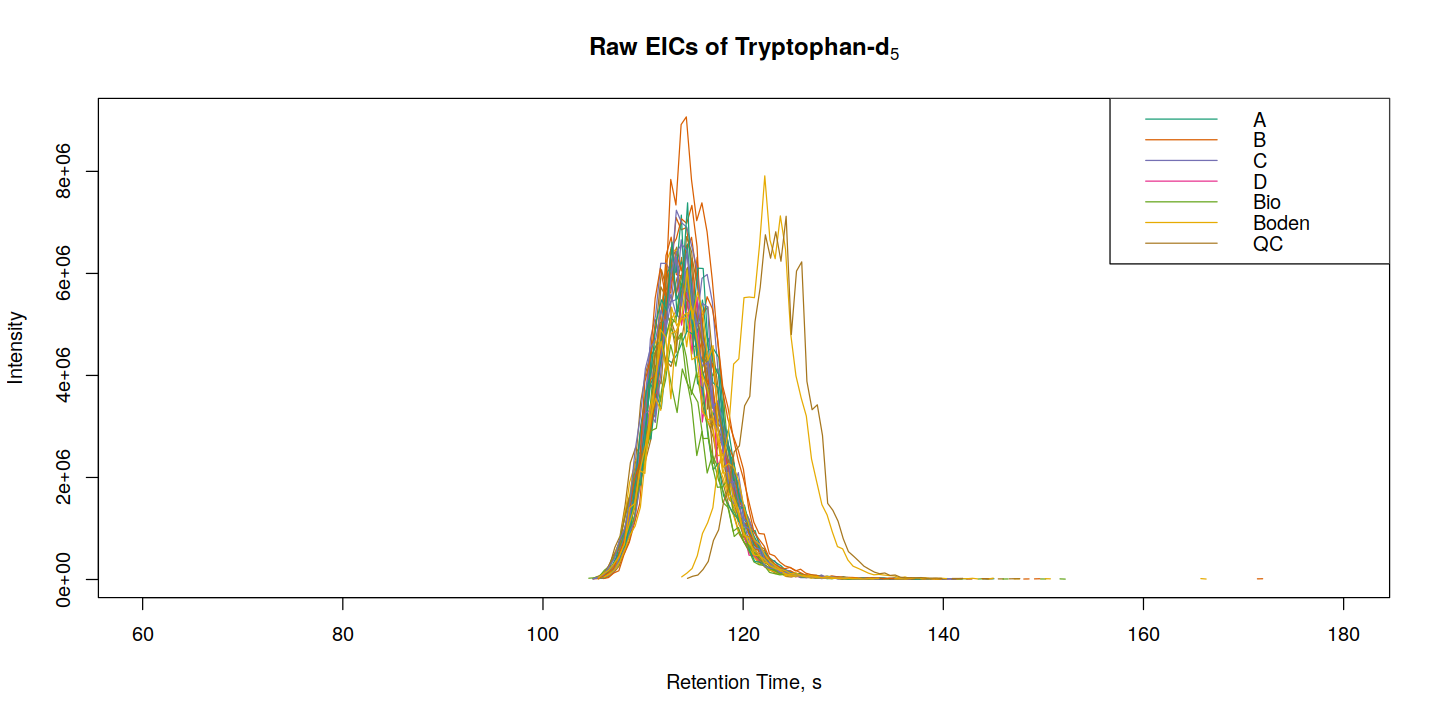

In [10]:
## Plot tryptophan-d5 before processing
trpd5.raw <- chromatogram(raw, mz = c(210.1280, 210.1290), rt = c(60, 180))

plot(trpd5.raw, col = group.colours[trpd5.raw$sample_group], 
     main = bquote(bold("Raw EICs of Tryptophan-d"[5])), xlab = "Retention Time, s", ylab = "Intensity")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

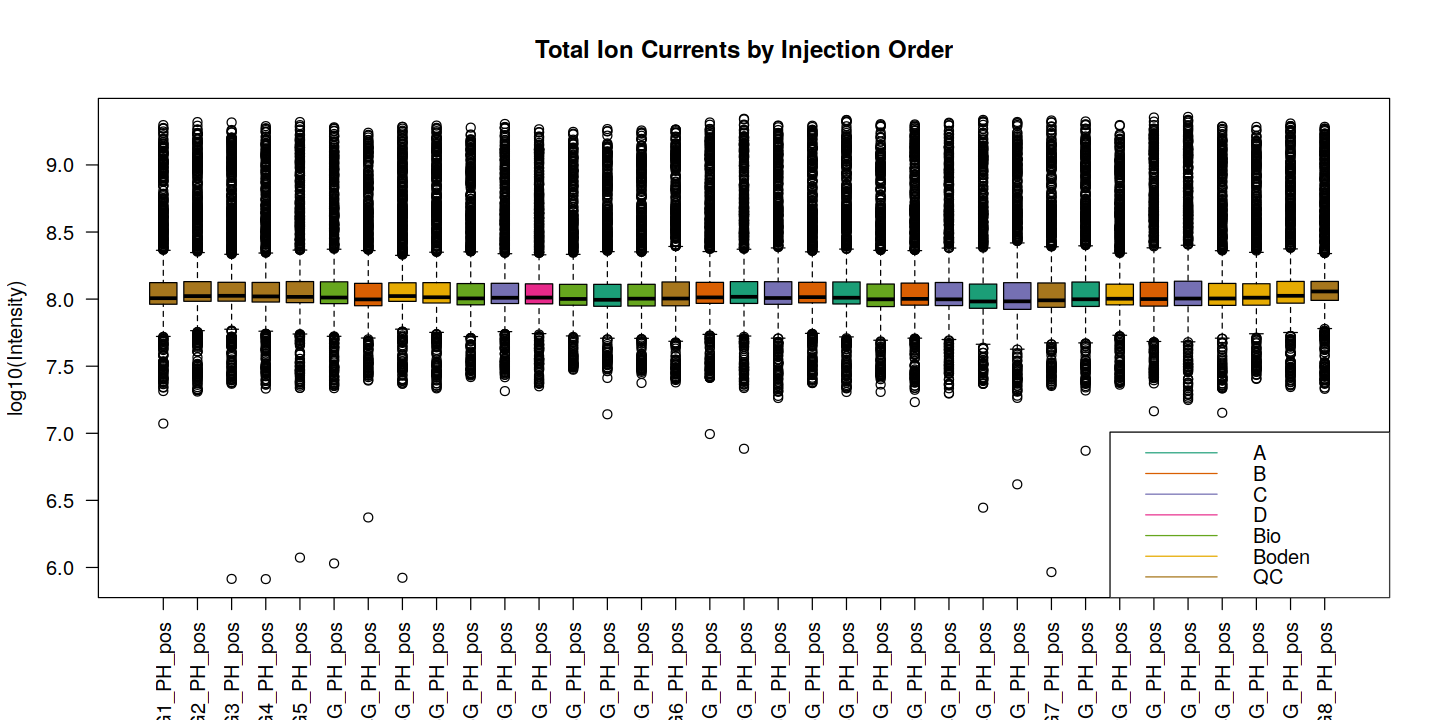

In [11]:
# Inspect boxplots of TICs by injection order
tics.summary <- split(tic(raw), f = fromFile(raw))

boxplot(sapply(tics.summary, log10), names = raw$sample_name, 
        col = group.colours[raw$sample_group], ylab = "log10(Intensity)", 
        main = "Total Ion Currents by Injection Order", las = 2)
legend("bottomright", legend = names(group.colours), 
       col = group.colours, lty = 1)

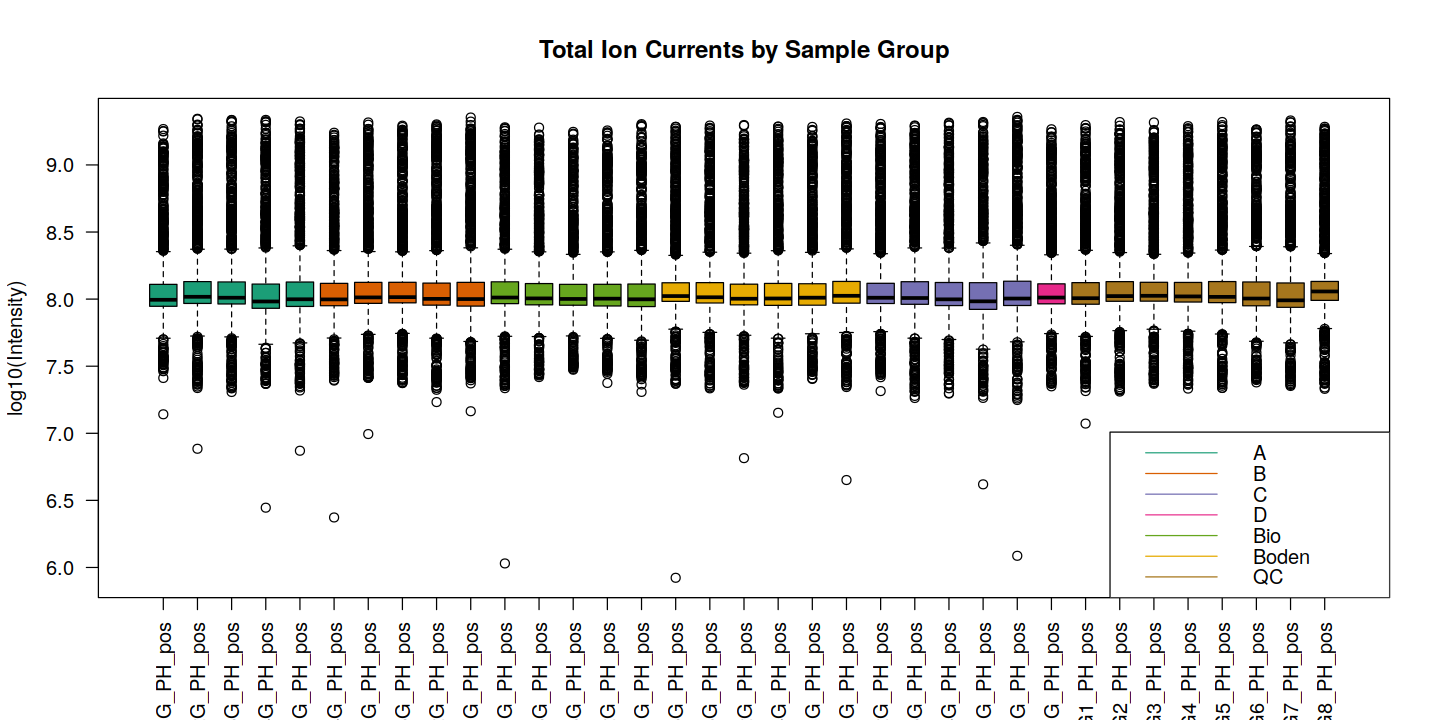

In [12]:
# Inspect boxplots of TICs by sample group
boxplot(sapply(tics.summary, log10)[,order(raw$sample_group)], 
        names = raw$sample_name[order(raw$sample_group)], 
        col = (group.colours[raw$sample_group])[order(raw$sample_group)], 
        ylab = "log10(Intensity)", 
        main = "Total Ion Currents by Sample Group", las = 2)
legend("bottomright", legend = names(group.colours), col = group.colours, lty = 1)

## Preprocessing of Raw Sample Files

### Peak Picking
Parameter used in this section were obtained using the one-by-one optimization performed by [centWaveOpt](https://github.com/saskema/centWaveOpt). This approach was published at [DOI: 10.1002/dta.2552](https://doi.org/10.1002/dta.2552) by Manier et al.

In [13]:
cwp <- CentWaveParam(peakwidth = c(7.8, 42), ppm = 2.2, snthresh = 25, 
                     mzdiff = 0.1,  prefilter = c(7, 5800))

suppressMessages(
    
    set <- findChromPeaks(raw, param = cwp)
    
    )

In [14]:
## Define sample colours
sample.colours <- paste0(brewer.pal(7, "Dark2")[1:7], "60")
names(sample.colours) <- c("A", "B", "C", "D", "Bio", "Boden", "QC")
sample.colours <- sample.colours[raw$sample_group]

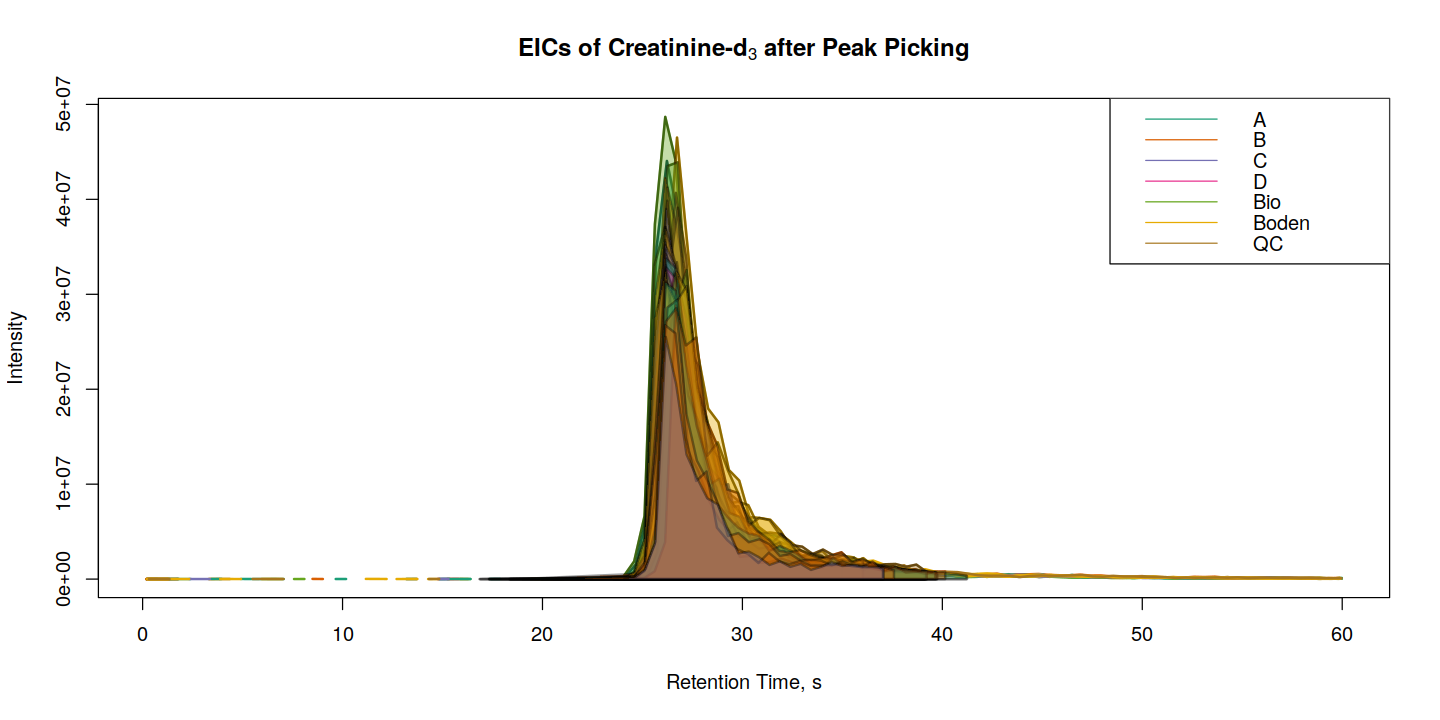

In [15]:
## Plot creatinine-d3 after peak picking
cread3.picked <- chromatogram(set, mz = c(117.0851, 117.0861), rt = c(0, 60)) 

plot(cread3.picked, col = group.colours[cread3.raw$sample_group], lwd = 2,
     peakBg = sample.colours[chromPeaks(cread3.picked)[, "sample"]],
     main = bquote(bold("EICs of Creatinine-d"[3]*" after Peak Picking")), xlab = "Retention Time, s",
     ylab = "Intensity")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

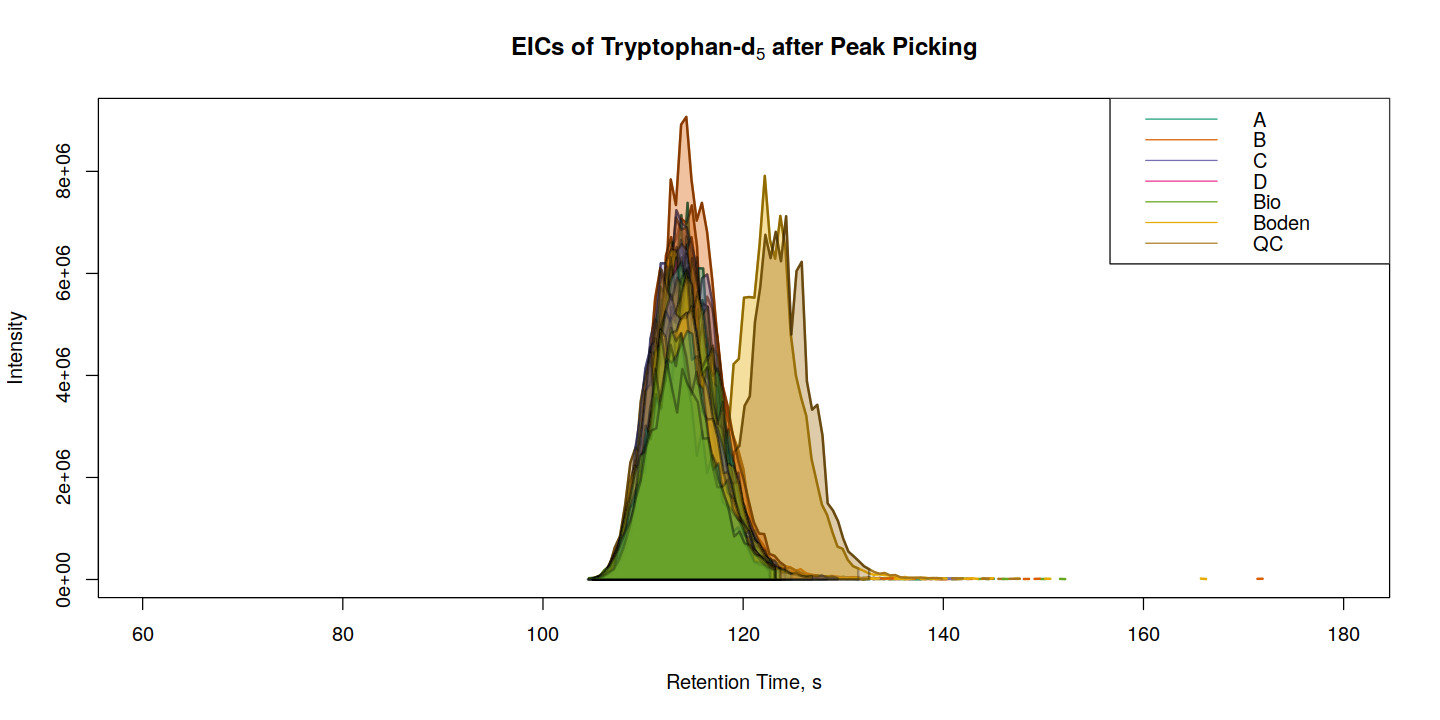

In [16]:
## Plot tryptophan-d5 after peak picking
trpd5.picked <- chromatogram(set, mz = c(210.1280, 210.1290), rt = c(60, 180)) 

plot(trpd5.picked, col = group.colours[trpd5.raw$sample_group], lwd = 2,
     peakBg = sample.colours[chromPeaks(trpd5.picked)[, "sample"]],
     main = bquote(bold("EICs of Tryptophan-d"[5]*" after Peak Picking")), xlab = "Retention Time, s",
     ylab = "Intensity")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

### Retention Time Correction (RT)

In [17]:
suppressMessages({
    
    set <- adjustRtime(set, param = ObiwarpParam(binSize = 0.6))
    set <- dropAdjustedRtime(set)

    pdp <- PeakDensityParam(sampleGroups = set$sample_group, bw = 0.6)
    set <- groupChromPeaks(set, param = pdp)

    ## Define subset alignment options and perform the alignment
    pgp <- PeakGroupsParam(minFraction = 0.85, 
                           subset = which(set$sample_group == "QC"),
                           subsetAdjust = "average", span = 0.8)
    set <- adjustRtime(set, param = pgp)
    
})

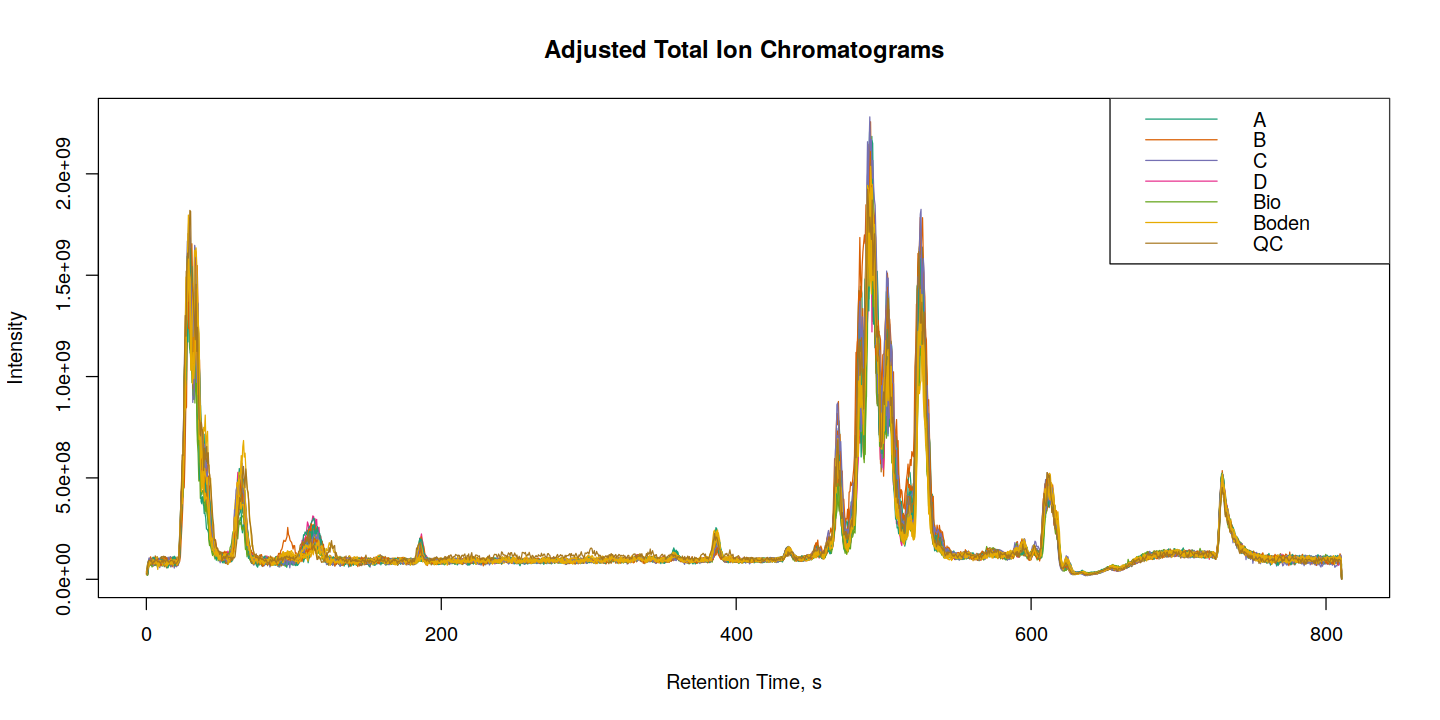

In [18]:
## Get the retention time-adjusted total ion chromatograms.
tics.corr <- chromatogram(set, aggregationFun = "sum")

plot(tics.corr, col = group.colours[tics.corr$sample_group], 
     peakType = "none", main = "Adjusted Total Ion Chromatograms", 
     xlab = "Retention Time, s", ylab = "Intensity")
legend("topright", legend = names(group.colours), col = group.colours, lty = 1)

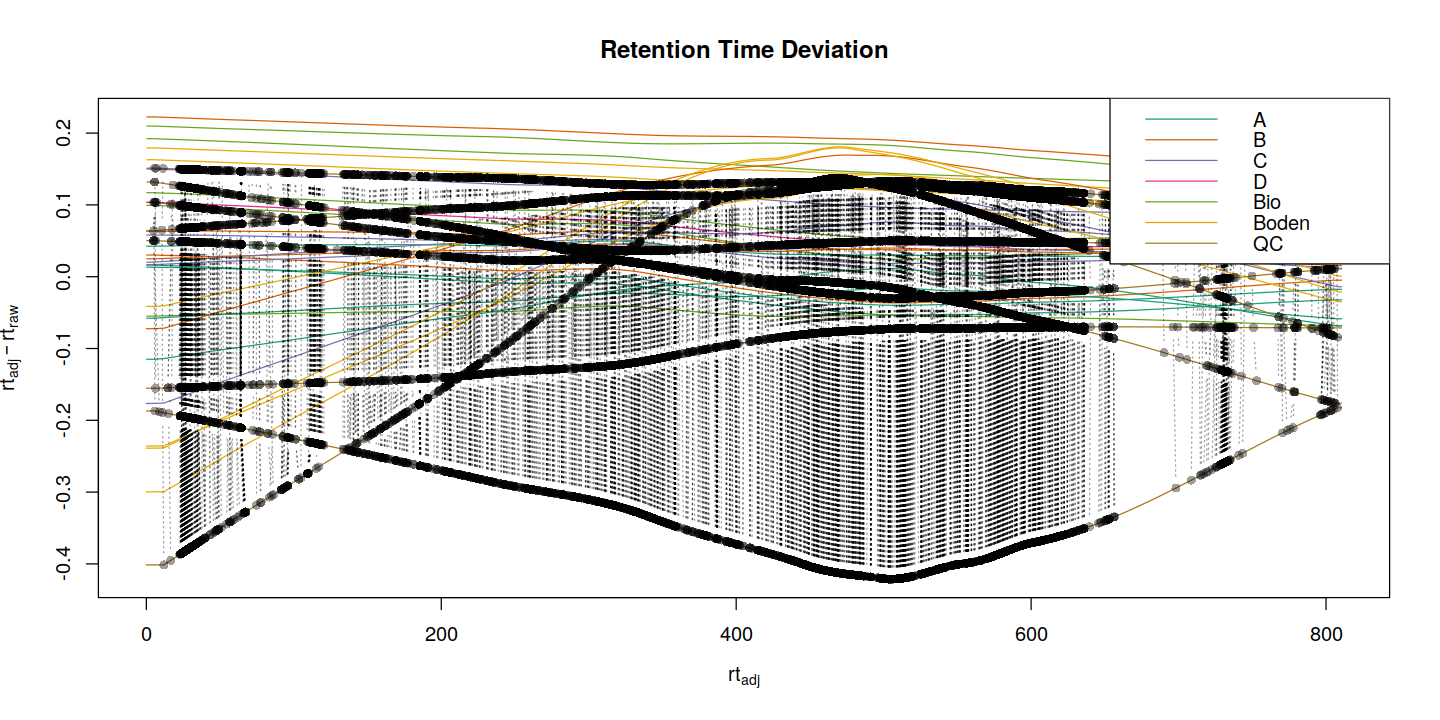

In [19]:
## Plot difference of adjusted to raw retention time.
plotAdjustedRtime(set, col = group.colours[set$sample_group], 
                  main = "Retention Time Deviation")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

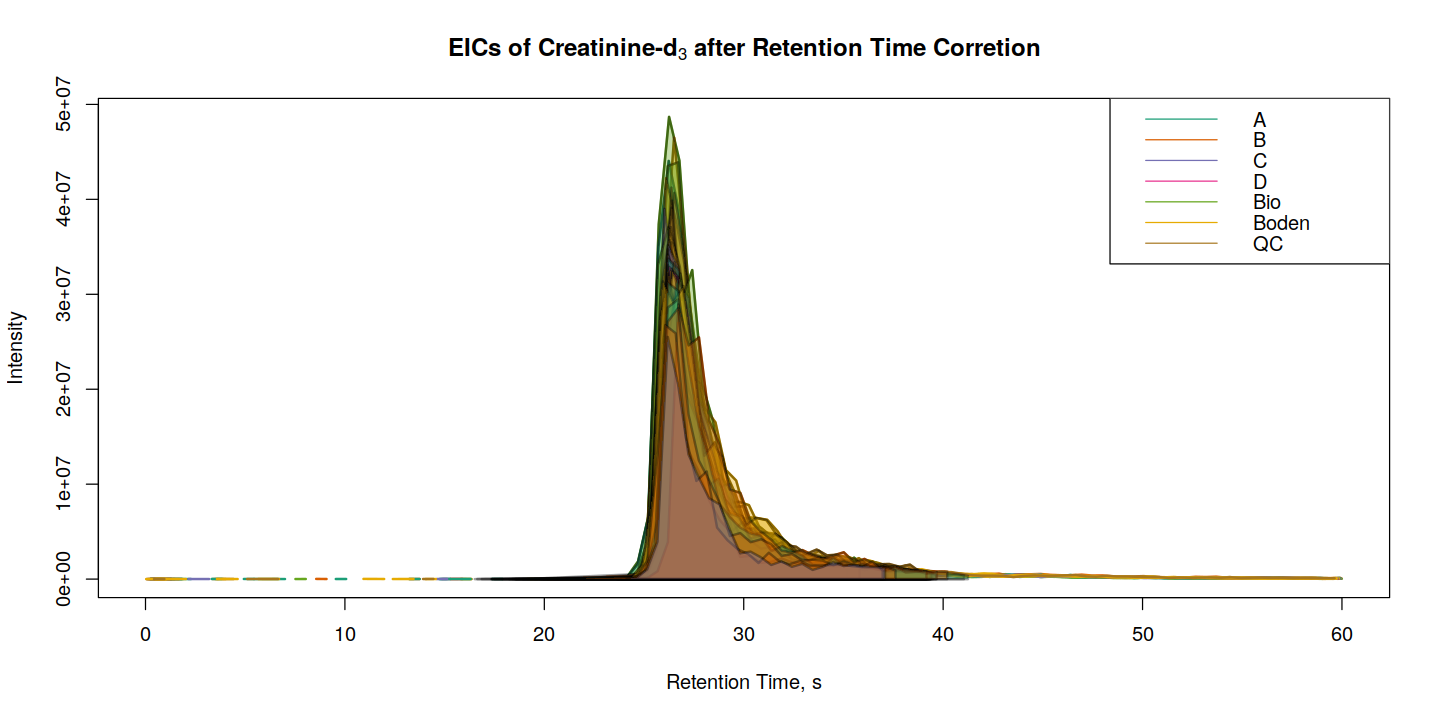

In [20]:
## Plot creatinine-d3 after retention time correction
cread3.corr <- chromatogram(set, mz = c(117.0851, 117.0861), rt = c(0, 60)) 

plot(cread3.corr, col = group.colours[cread3.raw$sample_group], lwd = 2,
     peakBg = sample.colours[chromPeaks(cread3.corr)[, "sample"]],
     main = bquote(bold("EICs of Creatinine-d"[3]*" after Retention Time Corretion")), xlab = "Retention Time, s",
     ylab = "Intensity")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

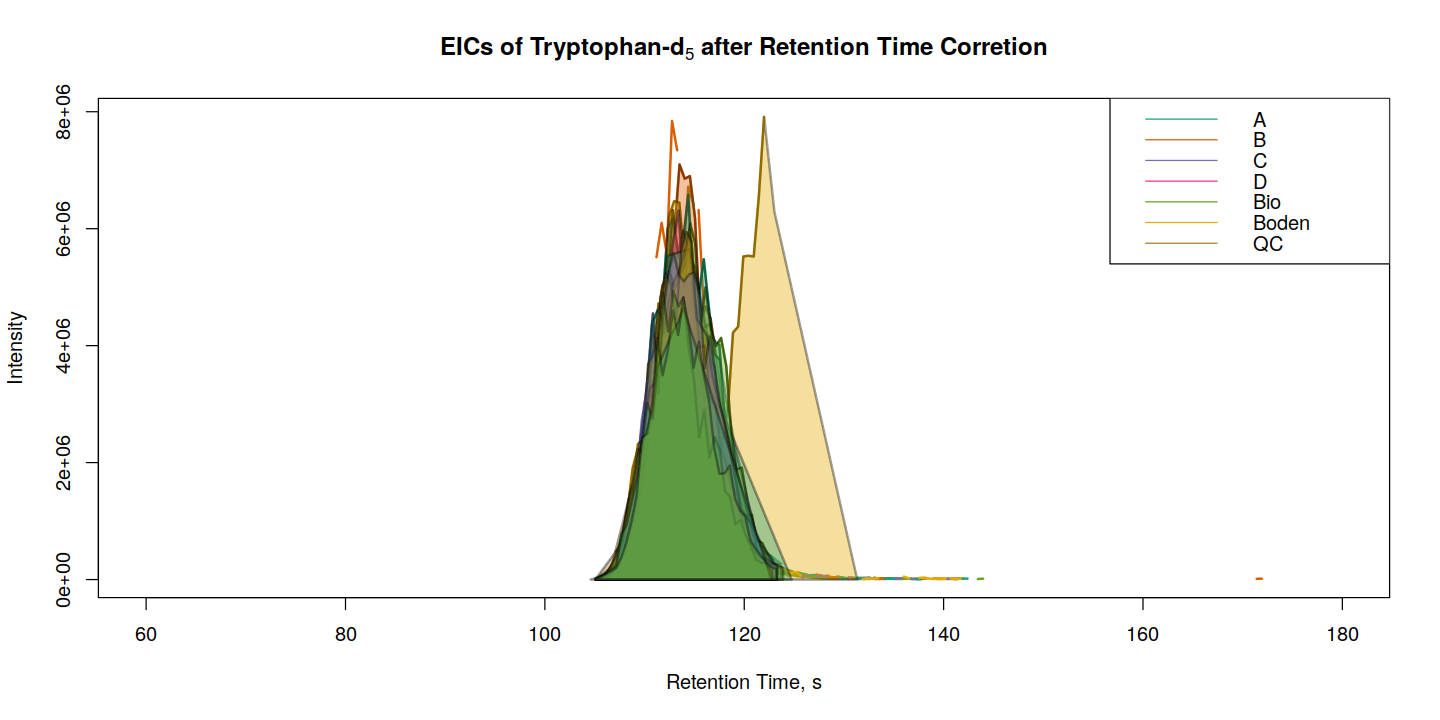

In [21]:
## Plot tryptophan-d5 after retention time correction
trpd5.corr <- chromatogram(set, mz = c(210.1287, 210.1296), rt = c(60, 180)) 

plot(trpd5.corr, col = group.colours[trpd5.raw$sample_group], lwd = 2,
     peakBg = sample.colours[chromPeaks(trpd5.corr)[, "sample"]],
     main = bquote(bold("EICs of Tryptophan-d"[5]*" after Retention Time Corretion")), xlab = "Retention Time, s",
     ylab = "Intensity")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

### Peak Grouping

In [22]:
suppressMessages(
    
    set <- groupChromPeaks(set, param = pdp)
    
)

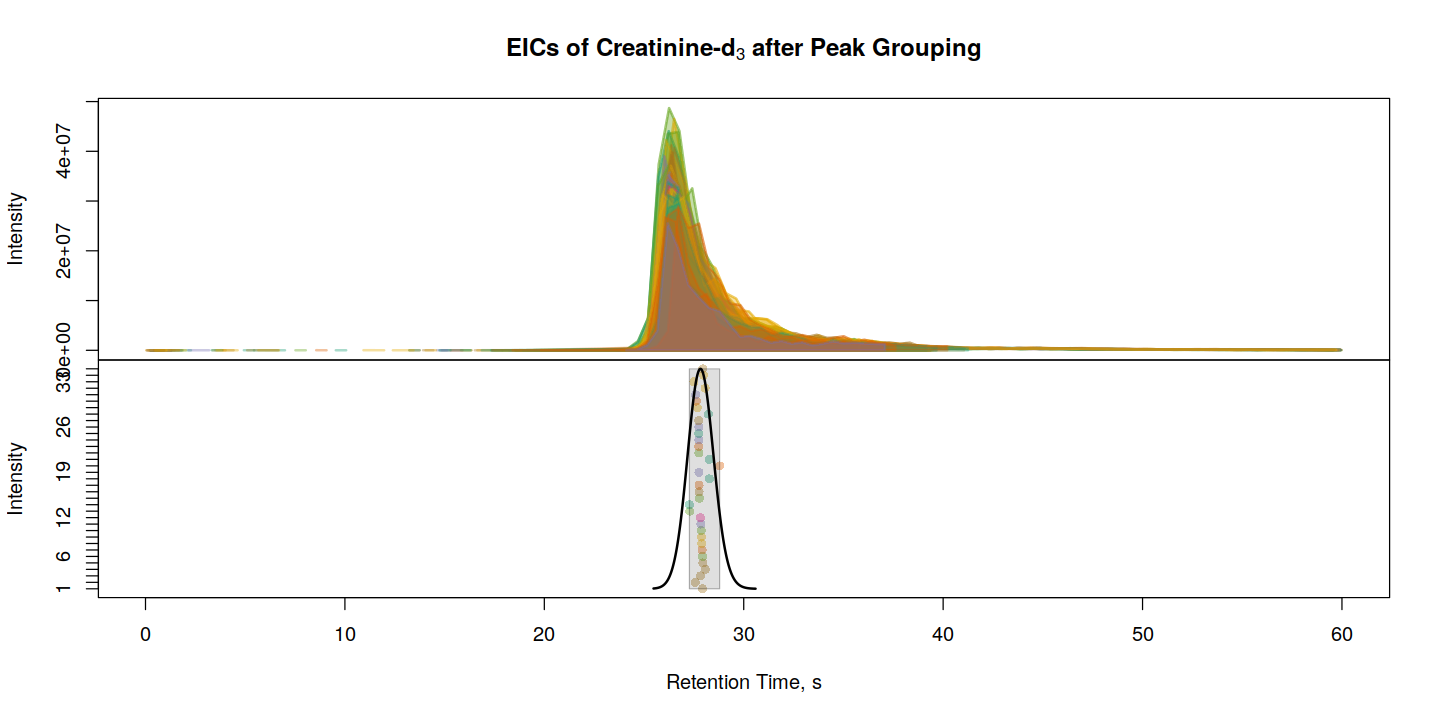

In [23]:
## Plot creatinine-d3 after peak grouping
cread3.grouped <- chromatogram(set, mz = c(117.0851, 117.0861), rt = c(0, 60))

## Define the parameters for the peak density method
plotChromPeakDensity(cread3.grouped, col = sample.colours, param = pdp, lwd = 2,
                     peakBg = sample.colours[chromPeaks(cread3.grouped)[, "sample"]],
                     peakCol = sample.colours[chromPeaks(cread3.grouped)[, "sample"]],
                     peakPch = 16, main = bquote(bold("EICs of Creatinine-d"[3]*" after Peak Grouping")),
                     xlab = "Retention Time, s", ylab = "Intensity")

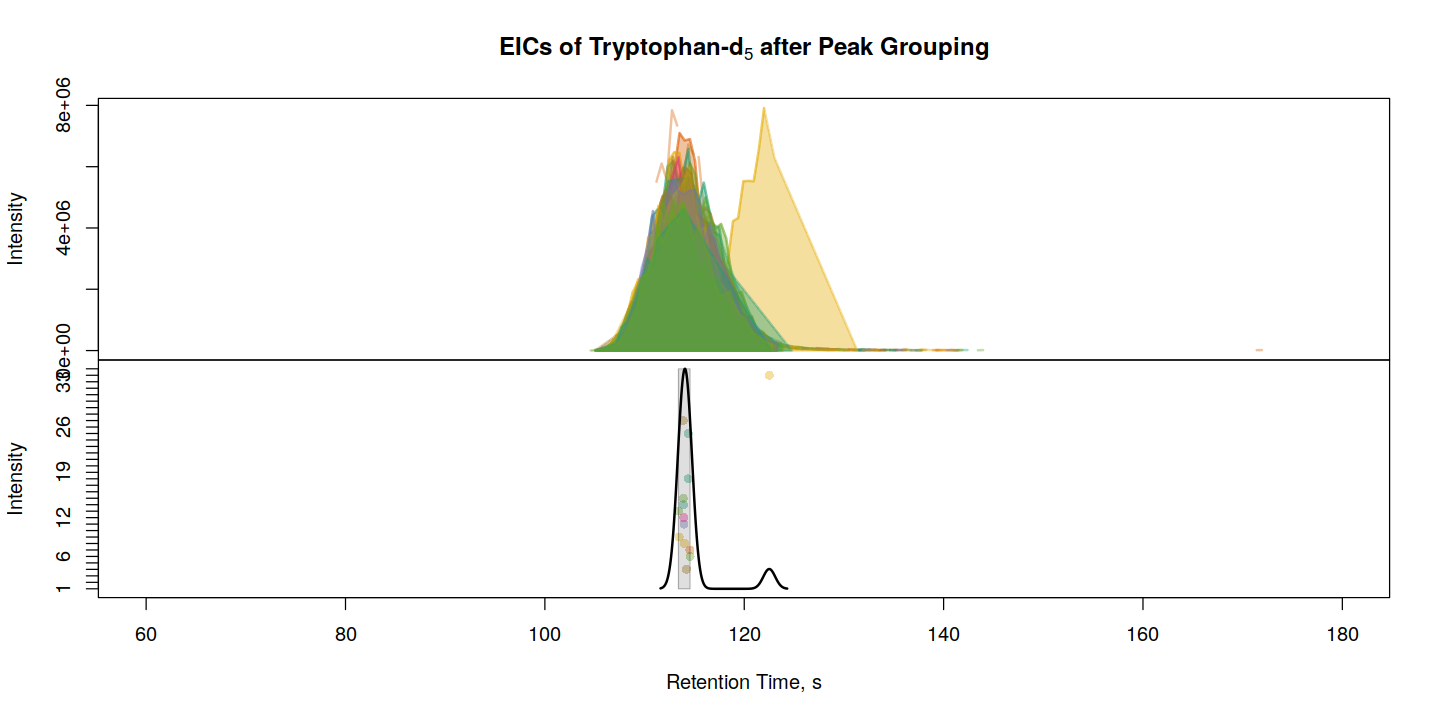

In [24]:
## Plot tryptophan-d5 after peak grouping
trpd5.grouped <- chromatogram(set, mz = c(210.1287, 210.1296), rt = c(60, 180))

## Define the parameters for the peak density method
plotChromPeakDensity(trpd5.grouped, col = sample.colours, param = pdp, lwd = 2,
                     peakBg = sample.colours[chromPeaks(trpd5.grouped)[, "sample"]],
                     peakCol = sample.colours[chromPeaks(trpd5.grouped)[, "sample"]],
                     peakPch = 16, main = bquote(bold("EICs of Tryptophan-d"[5]*" after Peak Grouping")),
                     xlab = "Retention Time, s", ylab = "Intensity")

### Peak Filling

In [25]:
suppressMessages(    
     
    set <- fillChromPeaks(set, param = ChromPeakAreaParam())
    
)

## Post Processing

### Export Results to SummarizedExperiment-Object

In [26]:
## Summarise experiment
results <- quantify(set, value = "into")

In [27]:
## Add classic feature names
rowData(results)$label <- paste0("M",round(rowData(results)$mzmed,0),
                           "T", round(rowData(results)$rtmed,0))

### Annotation of Adducts and Isotopes

In [28]:
## Perform annotation using CAMERA
suppressMessages({
    
    camera <- set %>%
              as("xcmsSet") %>%
              CAMERA::annotate(polarity  = "positive") %>%
              getPeaklist() %>%
              dplyr::select(isotopes, adduct, pcgroup)
    
})

## Save annotation results in SummarizedExperiment class
rowData(results)$isotopes <- camera$isotopes
rowData(results)$adduct <- camera$adduct
rowData(results)$pcgroup <- camera$pcgroup

Start grouping after retention time.
Created 201 pseudospectra.
Generating peak matrix!
Run isotope peak annotation
 % finished: 10  20  30  40  50  60  70  80  90  100  
Found isotopes: 919 
Start grouping after correlation.
Generating EIC's .. 

Calculating peak correlations in 201 Groups... 
 % finished: 10  20  30  40  50  60  70  80  90  100  

Calculating graph cross linking in 201 Groups... 
 % finished: 10  20  30  40  50  60  70  80  90  100  
New number of ps-groups:  1579 
xsAnnotate has now 1579 groups, instead of 201 
Generating peak matrix for peak annotation!

Calculating possible adducts in 1579 Groups... 
 % finished: 10  20  30  40  50  60  70  80  90  100  


In [29]:
# Replacing NAs with surrogate LOD
lod <- assay(results, "raw")[is.na(assay(results, "raw")) == FALSE] %>%
       min()
assay(results, "raw")[is.na(assay(results, "raw"))] <- lod

## Export data set for additional evaluations

In [30]:
write_xlsx(list(areas = as.data.frame(assay(results, "raw")), 
                peakdata = as.data.frame(rowData(results)), 
                filedata = as.data.frame(colData(results))), 
           "Eigelb_RP_pos.xlsx")

## Save dataset

In [31]:
save.image("Eigelb_RP_pos.RData")

## Export inclusion list after statistical evaluation

In [32]:
#suppressMessages({
#    
#    library("dplyr")
#    library("SummarizedExperiment")
#    load("Eigelb_RP_pos.RData")
#
#})   

features.gs <- c("M399T453", "M193T30", "M226T254", "M257T25", "M418T543", "M445T546", "M621T614")
inclusion.list.gs <- matrix(ncol = 12, nrow = length(features.gs), byrow = TRUE, 
                            dimnames = list(NULL, c("Mass [m/z]","Formula [M]",
                                                    "Formula type","Species","CS [z]",
                                                    "Polarity","Start [min]","End [min]",
                                                    "(N)CE","(N)CE type","MSX ID","Comment")))
summary.gs <- results %>%
              rowData() %>%
              as.data.frame() %>%
              filter(label %in% features.gs) %>%
              dplyr::select(label, mzmed, rtmed)

#features.gs[which(features.gs %notin% summary.gs$label)]

inclusion.list.gs[,1] <- round(summary.gs$mzmed,4)
inclusion.list.gs[,6] <- rep("pos", length(features.gs))
inclusion.list.gs[,7] <- round((summary.gs$rtmed - 30) / 60,2)
inclusion.list.gs[,8] <- round((summary.gs$rtmed + 30) / 60,2)
inclusion.list.gs[,12] <- summary.gs$label

write.csv(inclusion.list.gs, "inclusion_list_RP_pos_GS.csv", row.names = FALSE, quote = FALSE)

# Appendix

In [33]:
sessionInfo()

R version 4.2.2 (2022-10-31)
Platform: x86_64-suse-linux-gnu (64-bit)
Running under: openSUSE Leap 15.4

Matrix products: default
BLAS:   /usr/lib64/R/lib/libRblas.so
LAPACK: /usr/lib64/R/lib/libRlapack.so

locale:
 [1] LC_CTYPE=de_DE.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=de_DE.UTF-8        LC_COLLATE=de_DE.UTF-8    
 [5] LC_MONETARY=de_DE.UTF-8    LC_MESSAGES=de_DE.UTF-8   
 [7] LC_PAPER=de_DE.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=de_DE.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] writexl_1.4.1               ggrepel_0.9.1              
 [3] MASS_7.3-58.1               caret_6.0-92               
 [5] lattice_0.20-45             Rtsne_0.16                 
 [7] gplots_3.1.3                forcats_0.5.1              
 [9] stringr_1.4.0               dplyr_1.0.9    